In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

import warnings
warnings.filterwarnings("ignore")


In [2]:
csv_path = r"D:\ml\reviews.csv"
df = pd.read_csv(csv_path, parse_dates=["at","repliedAt"], low_memory=False)

df = df.dropna(subset=["content","score"])
df["score"] = pd.to_numeric(df["score"], errors="coerce").astype(int)

def score_to_sentiment(s):
    if s >= 4: return "positive"
    elif s <= 2: return "negative"
    return "neutral"

df["sentiment"] = df["score"].apply(score_to_sentiment)

def clean_text(s):
    s = s.lower()
    s = re.sub(r"http\S+|www\S+", " ", s)
    s = re.sub(r"[^a-z0-9\s]", " ", s)
    return re.sub(r"\s+", " ", s).strip()

df["content_clean"] = df["content"].apply(clean_text)

df["review_len"] = df["content_clean"].str.split().apply(len)
df["thumbsUpCount"] = pd.to_numeric(df["thumbsUpCount"], errors="coerce").fillna(0).astype(int)
df["thumbsUp_log1p"] = np.log1p(df["thumbsUpCount"])

num_features = ["review_len", "thumbsUp_log1p"]

print("Dataset shape:", df.shape)
df.head(3)


Dataset shape: (12495, 16)


,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,sortOrder,appId,sentiment,content_clean,review_len,thumbsUp_log1p
0,gp:AOqpTOEhZuqSqqWnaKRgv-9ABYdajFUB0WugPGh-SG-...,Eric Tie,https://play-lh.googleusercontent.com/a-/AOh14...,I cannot open the app anymore,1,0,5.4.0.6,2020-10-27 21:24:41,NaN,NaT,newest,com.anydo,negative,i cannot open the app anymore,6,0.0
1,gp:AOqpTOH0WP4IQKBZ2LrdNmFy_YmpPCVrV3diEU9KGm3...,john alpha,https://play-lh.googleusercontent.com/a-/AOh14...,I have been begging for a refund from this app...,1,0,NaN,2020-10-27 14:03:28,"Please note that from checking our records, yo...",2020-10-27 15:05:52,newest,com.anydo,negative,i have been begging for a refund from this app...,19,0.0
2,gp:AOqpTOEMCkJB8Iq1p-r9dPwnSYadA5BkPWTf32Z1azu...,Sudhakar .S,https://play-lh.googleusercontent.com/a-/AOh14...,Very costly for the premium version (approx In...,1,0,NaN,2020-10-27 08:18:40,NaN,NaT,newest,com.anydo,negative,very costly for the premium version approx ind...,36,0.0


In [3]:
X = df[["content_clean"] + num_features]
y = df["sentiment"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)


In [4]:
text_tfidf = TfidfVectorizer(max_features=30000, ngram_range=(1,2), stop_words="english")

preprocess = ColumnTransformer(
    transformers=[
        ("tfidf", text_tfidf, "content_clean"),
        ("num", StandardScaler(with_mean=False), num_features)
    ]
)


Naive Bayes Classification Report:
              precision    recall  f1-score   support

    negative       0.67      0.84      0.75       970
     neutral       1.00      0.00      0.01       398
    positive       0.75      0.85      0.80      1131

    accuracy                           0.71      2499
   macro avg       0.81      0.56      0.52      2499
weighted avg       0.76      0.71      0.65      2499



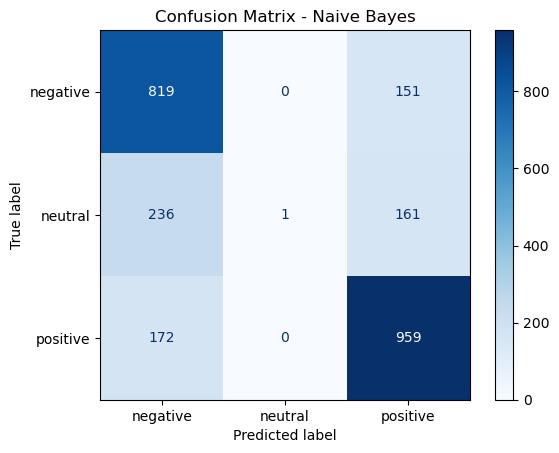

In [5]:
nb_pipeline = Pipeline([
    ("pre", preprocess),
    ("clf", MultinomialNB(alpha=0.5))
])

nb_pipeline.fit(X_train, y_train)
y_pred_nb = nb_pipeline.predict(X_test)

print("Naive Bayes Classification Report:")
print(classification_report(y_test, y_pred_nb))

cm_nb = confusion_matrix(y_test, y_pred_nb, labels=["negative","neutral","positive"])
disp_nb = ConfusionMatrixDisplay(cm_nb, display_labels=["negative","neutral","positive"])
disp_nb.plot(cmap="Blues")
plt.title("Confusion Matrix - Naive Bayes")
plt.show()


SVM Classification Report:
              precision    recall  f1-score   support

    negative       0.70      0.77      0.73       970
     neutral       0.33      0.13      0.19       398
    positive       0.75      0.85      0.80      1131

    accuracy                           0.70      2499
   macro avg       0.59      0.58      0.57      2499
weighted avg       0.67      0.70      0.68      2499



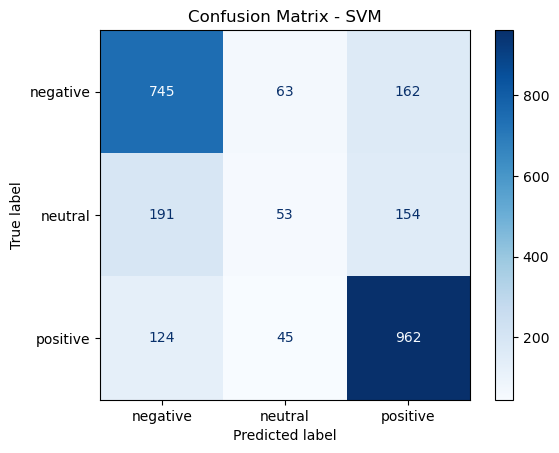

In [6]:
svm_pipeline = Pipeline([
    ("pre", preprocess),
    ("clf", LinearSVC())
])

svm_pipeline.fit(X_train, y_train)
y_pred_svm = svm_pipeline.predict(X_test)

print("SVM Classification Report:")
print(classification_report(y_test, y_pred_svm))

cm_svm = confusion_matrix(y_test, y_pred_svm, labels=["negative","neutral","positive"])
disp_svm = ConfusionMatrixDisplay(cm_svm, display_labels=["negative","neutral","positive"])
disp_svm.plot(cmap="Blues")
plt.title("Confusion Matrix - SVM")
plt.show()


Random Forest Classification Report:
              precision    recall  f1-score   support

    negative       0.68      0.82      0.74       970
     neutral       0.39      0.02      0.03       398
    positive       0.74      0.86      0.80      1131

    accuracy                           0.71      2499
   macro avg       0.60      0.57      0.53      2499
weighted avg       0.66      0.71      0.66      2499



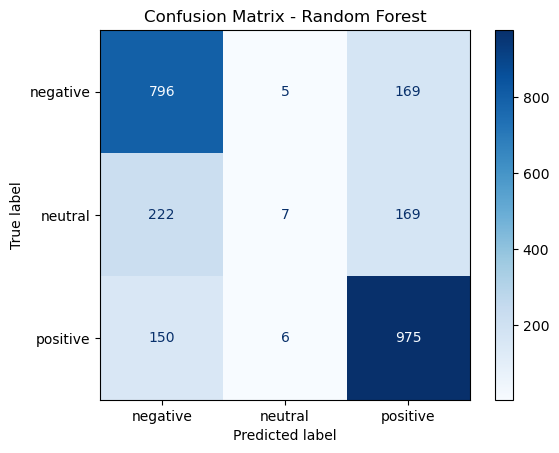

In [7]:
rf_pipeline = Pipeline([
    ("pre", preprocess),
    ("clf", RandomForestClassifier(
        n_estimators=200, random_state=42, n_jobs=-1
    ))
])

rf_pipeline.fit(X_train, y_train)
y_pred_rf = rf_pipeline.predict(X_test)

print("Random Forest Classification Report:")
print(classification_report(y_test, y_pred_rf))

cm_rf = confusion_matrix(y_test, y_pred_rf, labels=["negative","neutral","positive"])
disp_rf = ConfusionMatrixDisplay(cm_rf, display_labels=["negative","neutral","positive"])
disp_rf.plot(cmap="Blues")
plt.title("Confusion Matrix - Random Forest")
plt.show()


In [8]:
from sklearn.metrics import f1_score

macro_f1_nb  = f1_score(y_test, y_pred_nb,  average="macro")
macro_f1_svm = f1_score(y_test, y_pred_svm, average="macro")
macro_f1_rf  = f1_score(y_test, y_pred_rf,  average="macro")

results_df = pd.DataFrame({
    "Model": ["Naive Bayes", "SVM", "Random Forest"],
    "Macro-F1": [macro_f1_nb, macro_f1_svm, macro_f1_rf]
})

print(results_df.sort_values("Macro-F1", ascending=False))


           Model  Macro-F1
1            SVM  0.574095
2  Random Forest  0.525382
0    Naive Bayes  0.516359


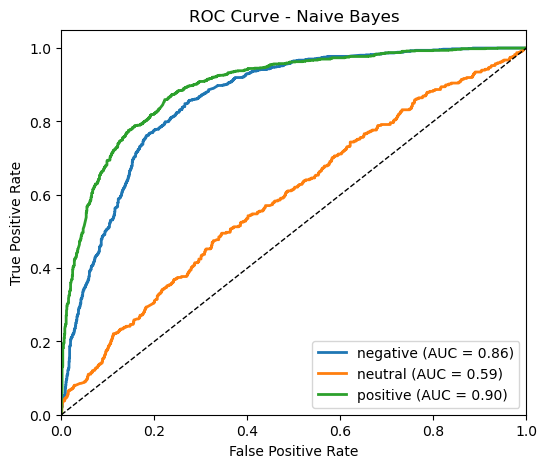

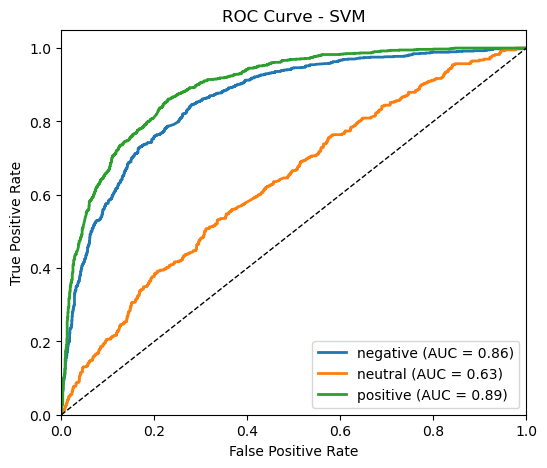

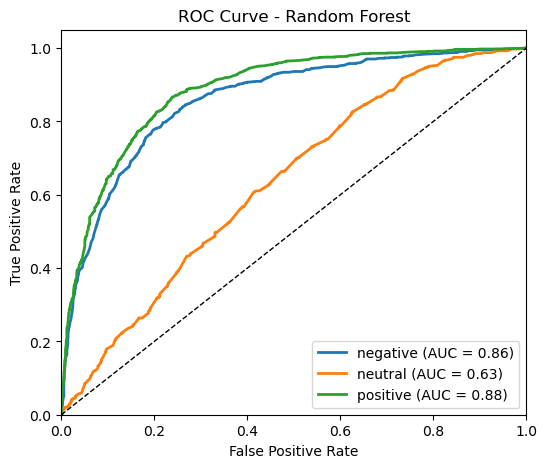

In [9]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from sklearn.multiclass import OneVsRestClassifier
from sklearn.pipeline import make_pipeline

classes = ["negative","neutral","positive"]
y_test_bin = label_binarize(y_test, classes=classes)
n_classes = y_test_bin.shape[1]

def plot_multiclass_roc(model, X_test, y_test_bin, model_name):
    if hasattr(model, "predict_proba"):
        y_score = model.predict_proba(X_test)
    else:
        y_score = model.decision_function(X_test)

    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    plt.figure(figsize=(6, 5))
    for i, cls in enumerate(classes):
        plt.plot(fpr[i], tpr[i], lw=2,
                 label=f"{cls} (AUC = {roc_auc[i]:.2f})")
    plt.plot([0, 1], [0, 1], 'k--', lw=1)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curve - {model_name}")
    plt.legend(loc="lower right")
    plt.show()

plot_multiclass_roc(nb_pipeline, X_test, y_test_bin, "Naive Bayes")
plot_multiclass_roc(svm_pipeline, X_test, y_test_bin, "SVM")
plot_multiclass_roc(rf_pipeline, X_test, y_test_bin, "Random Forest")


In [10]:
from sklearn.metrics import accuracy_score, f1_score

nb_acc  = accuracy_score(y_test, y_pred_nb)
svm_acc = accuracy_score(y_test, y_pred_svm)
rf_acc  = accuracy_score(y_test, y_pred_rf)

nb_f1  = f1_score(y_test, y_pred_nb, average="macro")
svm_f1 = f1_score(y_test, y_pred_svm, average="macro")
rf_f1  = f1_score(y_test, y_pred_rf, average="macro")

import pandas as pd
results_df = pd.DataFrame({
    "Model": ["Naive Bayes", "SVM", "Random Forest"],
    "Accuracy": [nb_acc, svm_acc, rf_acc],
    "Macro-F1": [nb_f1, svm_f1, rf_f1]
})

results_df


,Model,Accuracy,Macro-F1
0,Naive Bayes,0.711885,0.516359
1,SVM,0.704282,0.574095
2,Random Forest,0.711485,0.525382


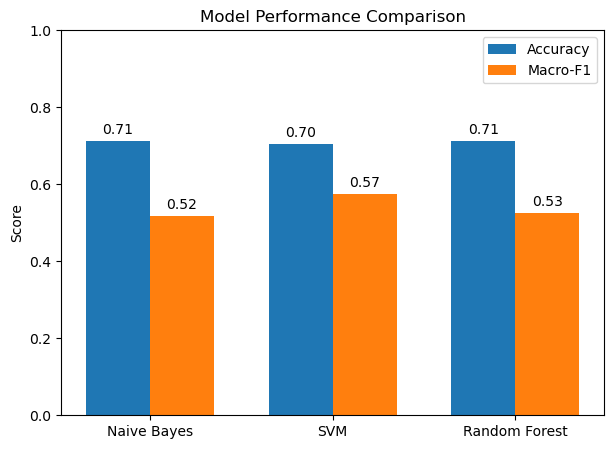

In [11]:
import matplotlib.pyplot as plt
import numpy as np

x = np.arange(len(results_df["Model"]))  # model positions
width = 0.35  

fig, ax = plt.subplots(figsize=(7, 5))
bars1 = ax.bar(x - width/2, results_df["Accuracy"], width, label="Accuracy")
bars2 = ax.bar(x + width/2, results_df["Macro-F1"], width, label="Macro-F1")

ax.set_ylabel("Score")
ax.set_title("Model Performance Comparison")
ax.set_xticks(x)
ax.set_xticklabels(results_df["Model"])
ax.set_ylim(0, 1)
ax.legend()

for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(bar.get_x() + bar.get_width()/2, height),
                    xytext=(0, 3),  # offset
                    textcoords="offset points",
                    ha="center", va="bottom")

plt.show()


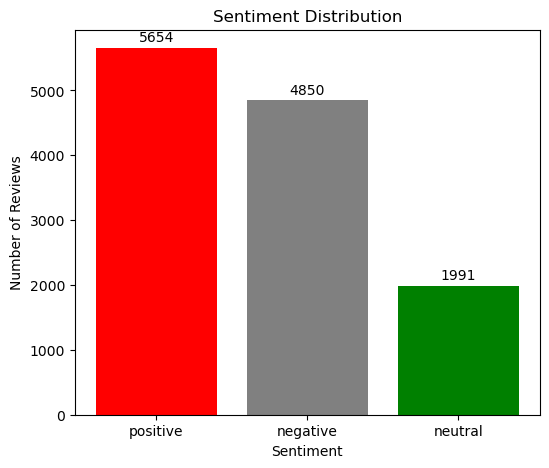

In [15]:
import matplotlib.pyplot as plt

sentiment_counts = df["sentiment"].value_counts()

plt.figure(figsize=(6,5))
bars = plt.bar(sentiment_counts.index, sentiment_counts.values, color=["red","gray","green"])
plt.title("Sentiment Distribution")
plt.xlabel("Sentiment")
plt.ylabel("Number of Reviews")

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 50, int(yval),
             ha="center", va="bottom", fontsize=10)

plt.show()


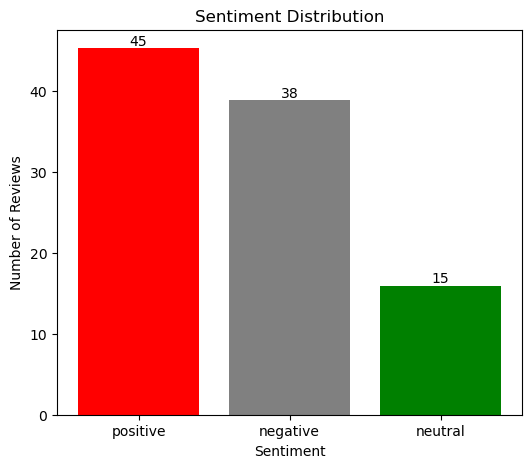

In [19]:

sentiment_counts = df["sentiment"].value_counts(normalize=True) * 100

plt.figure(figsize=(6,5))
bars = plt.bar(sentiment_counts.index, sentiment_counts.values, color=["red","gray","green"])
plt.title("Sentiment Distribution")
plt.xlabel("Sentiment")
plt.ylabel("Number of Reviews")

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval , int(yval),
             ha="center", va="bottom", fontsize=10)

plt.show()

79/79 ━━━━━━━━━━━━━━━━━━━━ 12s 130ms/step
LSTM Classification Report:
              precision    recall  f1-score   support

    negative       0.00      0.00      0.00       970
     neutral       0.00      0.00      0.00       398
    positive       0.45      1.00      0.62      1131

    accuracy                           0.45      2499
   macro avg       0.15      0.33      0.21      2499
weighted avg       0.20      0.45      0.28      2499



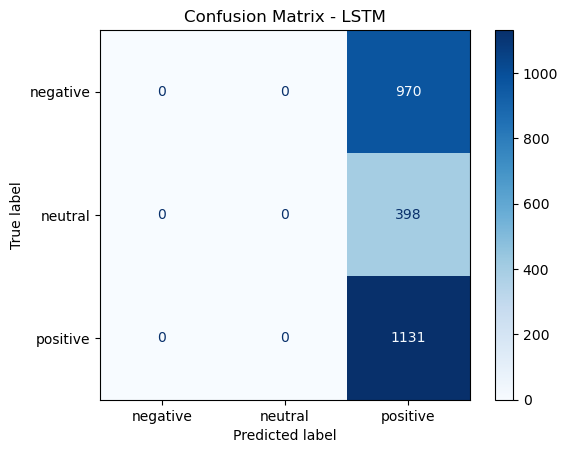

In [25]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import numpy as np

y_pred_probs = lstm_model.predict(X_test_pad)
y_pred_classes = np.argmax(y_pred_probs, axis=1)
y_true_classes = np.argmax(y_test_enc, axis=1)

print("LSTM Classification Report:")
print(classification_report(y_true_classes, y_pred_classes, target_names=classes))

cm_lstm = confusion_matrix(y_true_classes, y_pred_classes)
disp_lstm = ConfusionMatrixDisplay(cm_lstm, display_labels=classes)
disp_lstm.plot(cmap="Blues")
plt.title("Confusion Matrix - LSTM")
plt.show()


In [27]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.utils.class_weight import compute_class_weight
import numpy as np


In [28]:
max_words = 20000 
max_len = 200     
embedding_dim = 100 


tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train["content_clean"])

X_train_seq = tokenizer.texts_to_sequences(X_train["content_clean"])
X_test_seq  = tokenizer.texts_to_sequences(X_test["content_clean"])

X_train_pad = pad_sequences(X_train_seq, maxlen=max_len, padding='post', truncating='post')
X_test_pad  = pad_sequences(X_test_seq, maxlen=max_len, padding='post', truncating='post')

classes = ["negative","neutral","positive"]

y_train_int = np.array([classes.index(c) for c in y_train])
y_test_int  = np.array([classes.index(c) for c in y_test])

y_train_enc = to_categorical(y_train_int, num_classes=len(classes))
y_test_enc  = to_categorical(y_test_int, num_classes=len(classes))


In [29]:
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train_int),
    y=y_train_int
)
class_weights = dict(enumerate(class_weights))
print("Class weights:", class_weights)


Class weights: {0: np.float64(0.8587628865979381), 1: np.float64(2.0916509730069053), 2: np.float64(0.7366791952244086)}


In [35]:
lstm_model = Sequential()
lstm_model.add(Embedding(max_words, embedding_dim, input_length=max_len))
lstm_model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
lstm_model.add(Dense(64, activation='relu'))
lstm_model.add(Dropout(0.5))
lstm_model.add(Dense(len(classes), activation='softmax'))

lstm_model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

lstm_model.summary()


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Logistic Regression Classification Report:
              precision    recall  f1-score   support

    negative       0.71      0.75      0.73       970
     neutral       0.32      0.34      0.33       398
    positive       0.82      0.76      0.79      1131

    accuracy                           0.69      2499
   macro avg       0.62      0.62      0.62      2499
weighted avg       0.70      0.69      0.69      2499



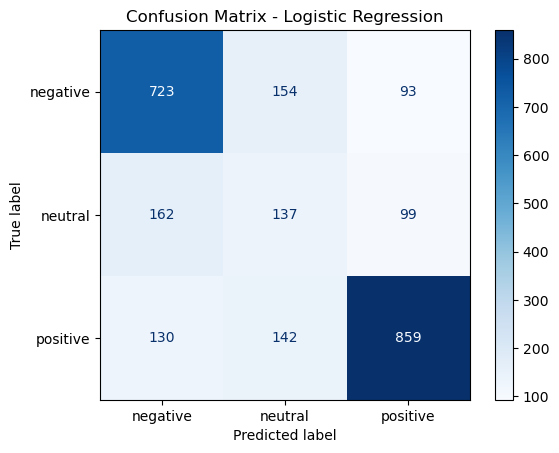

In [36]:
from sklearn.linear_model import LogisticRegression

lr_pipeline = Pipeline([
    ("pre", preprocess),
    ("clf", LogisticRegression(max_iter=1000, class_weight='balanced'))
])

lr_pipeline.fit(X_train, y_train)

y_pred_lr = lr_pipeline.predict(X_test)

print("Logistic Regression Classification Report:")
print(classification_report(y_test, y_pred_lr))

cm_lr = confusion_matrix(y_test, y_pred_lr, labels=["negative","neutral","positive"])
disp_lr = ConfusionMatrixDisplay(cm_lr, display_labels=["negative","neutral","positive"])
disp_lr.plot(cmap="Blues")
plt.title("Confusion Matrix - Logistic Regression")
plt.show()


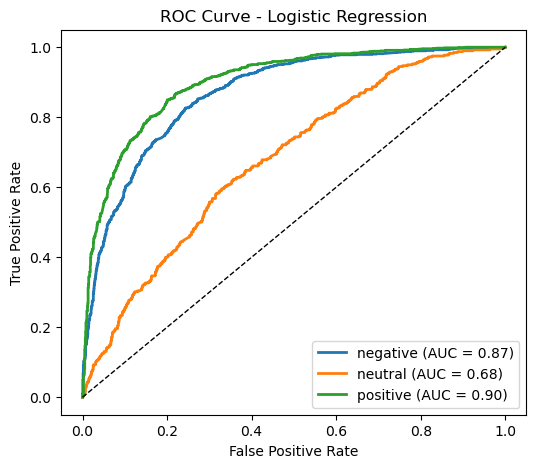

In [33]:
if hasattr(lr_pipeline.named_steps['clf'], "predict_proba"):
    y_score_lr = lr_pipeline.predict_proba(X_test)
else:
    y_score_lr = lr_pipeline.decision_function(X_test)

from sklearn.preprocessing import label_binarize

y_test_bin = label_binarize(y_test, classes=["negative","neutral","positive"])
fpr = dict()
tpr = dict()
roc_auc = dict()

for i, cls in enumerate(["negative","neutral","positive"]):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score_lr[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(6,5))
for i, cls in enumerate(["negative","neutral","positive"]):
    plt.plot(fpr[i], tpr[i], lw=2, label=f"{cls} (AUC = {roc_auc[i]:.2f})")
plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Logistic Regression")
plt.legend(loc="lower right")
plt.show()


In [34]:
from sklearn.metrics import accuracy_score, f1_score

nb_acc  = accuracy_score(y_test, y_pred_nb)
svm_acc = accuracy_score(y_test, y_pred_svm)
rf_acc  = accuracy_score(y_test, y_pred_rf)
lr_acc  = accuracy_score(y_test, y_pred_lr)

nb_f1  = f1_score(y_test, y_pred_nb, average="macro")
svm_f1 = f1_score(y_test, y_pred_svm, average="macro")
rf_f1  = f1_score(y_test, y_pred_rf, average="macro")
lr_f1  = f1_score(y_test, y_pred_lr, average="macro")

results_df = pd.DataFrame({
    "Model": ["Naive Bayes", "SVM", "Random Forest","Logistic Regression"],
    "Accuracy": [nb_acc, svm_acc, rf_acc, lr_acc],
    "Macro-F1": [nb_f1, svm_f1, rf_f1, lr_f1]
})

results_df


,Model,Accuracy,Macro-F1
0,Naive Bayes,0.711885,0.516359
1,SVM,0.704282,0.574095
2,Random Forest,0.711485,0.525382
3,Logistic Regression,0.687875,0.615179


In [37]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, f1_score

nb_model = MultinomialNB()

classes = np.unique(y_train)

chunk_size = 1000
for i in range(0, len(X_train), chunk_size):
    X_chunk = X_train.iloc[i:i+chunk_size]
    y_chunk = y_train.iloc[i:i+chunk_size]
    
    if i == 0:
        nb_model.partial_fit(preprocess.fit_transform(X_chunk), y_chunk, classes=classes)
    else:
        nb_model.partial_fit(preprocess.transform(X_chunk), y_chunk)

    y_val_pred = nb_model.predict(preprocess.transform(X_test))
    acc = accuracy_score(y_test, y_val_pred)
    f1 = f1_score(y_test, y_val_pred, average='macro')
    print(f"After batch {i//chunk_size+1}: Accuracy={acc:.4f}, Macro-F1={f1:.4f}")


After batch 1: Accuracy=0.6607, Macro-F1=0.4763
After batch 2: Accuracy=0.6851, Macro-F1=0.4961
After batch 3: Accuracy=0.6923, Macro-F1=0.5014
After batch 4: Accuracy=0.6963, Macro-F1=0.5040
After batch 5: Accuracy=0.7015, Macro-F1=0.5073
After batch 6: Accuracy=0.7015, Macro-F1=0.5074
After batch 7: Accuracy=0.7039, Macro-F1=0.5091
After batch 8: Accuracy=0.7043, Macro-F1=0.5092
After batch 9: Accuracy=0.7071, Macro-F1=0.5127
After batch 10: Accuracy=0.7071, Macro-F1=0.5113


In [38]:
!pip install memory_profiler


In [42]:
import time
import sys
from memory_profiler import memory_usage
import pandas as pd

def evaluate_model(model, X_train, y_train, X_test, y_test):
    start_time = time.time()
    mem_usage_train = memory_usage((model.fit, (X_train, y_train)), max_iterations=1)
    train_time = time.time() - start_time
    peak_memory_train = max(mem_usage_train) - min(mem_usage_train)
    
    start_time = time.time()
    mem_usage_pred = memory_usage((model.predict, (X_test,)), max_iterations=1)
    pred_time = time.time() - start_time
    peak_memory_pred = max(mem_usage_pred) - min(mem_usage_pred)
    
    model_size_mb = sys.getsizeof(model) / (1024 * 1024)
    
    return {
        "Training Time (s)": train_time,
        "Prediction Time (s)": pred_time,
        "Training Peak Memory (MB)": peak_memory_train,
        "Prediction Peak Memory (MB)": peak_memory_pred,
        "Model Size (MB)": model_size_mb
    }


In [40]:
nb_metrics = evaluate_model(nb_pipeline, X_train, y_train, X_test, y_test)
print(nb_metrics)


{'Training Time (s)': 2.5593321323394775, 'Prediction Time (s)': 1.024611473083496, 'Training Peak Memory (MB)': 43.765625, 'Prediction Peak Memory (MB)': 1.6640625, 'Model Size (MB)': 4.57763671875e-05}


In [41]:
results_list = []

results_list.append({"Model": "Naive Bayes", **evaluate_model(nb_pipeline, X_train, y_train, X_test, y_test)})

results_list.append({"Model": "SVM", **evaluate_model(svm_pipeline, X_train, y_train, X_test, y_test)})

results_list.append({"Model": "Random Forest", **evaluate_model(rf_pipeline, X_train, y_train, X_test, y_test)})

results_list.append({"Model": "Logistic Regression", **evaluate_model(lr_pipeline, X_train, y_train, X_test, y_test)})

results_df = pd.DataFrame(results_list)
results_df


,Model,Training Time (s),Prediction Time (s),Training Peak Memory (MB),Prediction Peak Memory (MB),Model Size (MB)
0,Naive Bayes,2.637352,1.121947,9.203125,0.000000,0.000046
1,SVM,8.842473,1.428543,9.160156,0.035156,0.000046
2,Random Forest,47.312364,1.594705,165.265625,2.097656,0.000046
3,Logistic Regression,7.689954,1.078887,33.328125,0.777344,0.000046


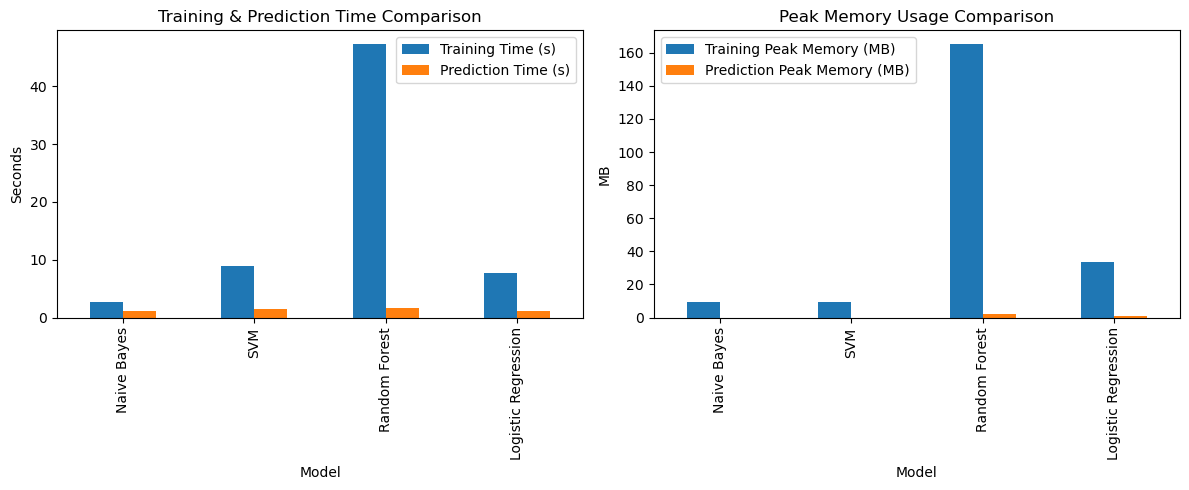

In [43]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(12, 5))

results_df.plot(x="Model", y=["Training Time (s)", "Prediction Time (s)"], kind="bar", ax=ax[0])
ax[0].set_title("Training & Prediction Time Comparison")
ax[0].set_ylabel("Seconds")

results_df.plot(x="Model", y=["Training Peak Memory (MB)", "Prediction Peak Memory (MB)"], kind="bar", ax=ax[1])
ax[1].set_title("Peak Memory Usage Comparison")
ax[1].set_ylabel("MB")

plt.tight_layout()
plt.show()


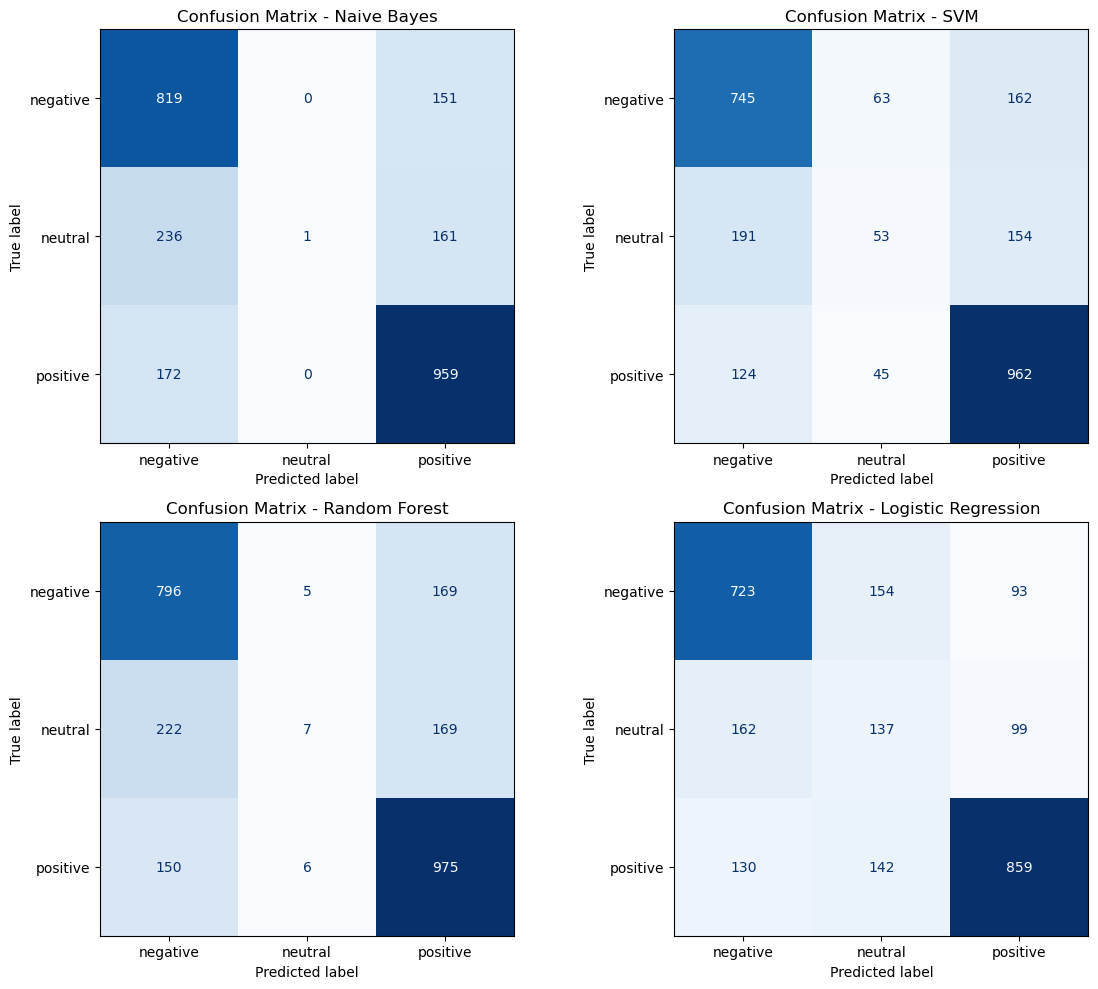

In [44]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

models = [
    (nb_pipeline, "Naive Bayes"),
    (svm_pipeline, "SVM"),
    (rf_pipeline, "Random Forest"),
    (lr_pipeline, "Logistic Regression")
]

fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

for idx, (model, title) in enumerate(models):
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred, labels=["negative", "neutral", "positive"])
    
    disp = ConfusionMatrixDisplay(cm, display_labels=["negative", "neutral", "positive"])
    disp.plot(ax=axes[idx], cmap="Blues", values_format='d', colorbar=False)
    axes[idx].set_title(f"Confusion Matrix - {title}")

plt.tight_layout()
plt.show()


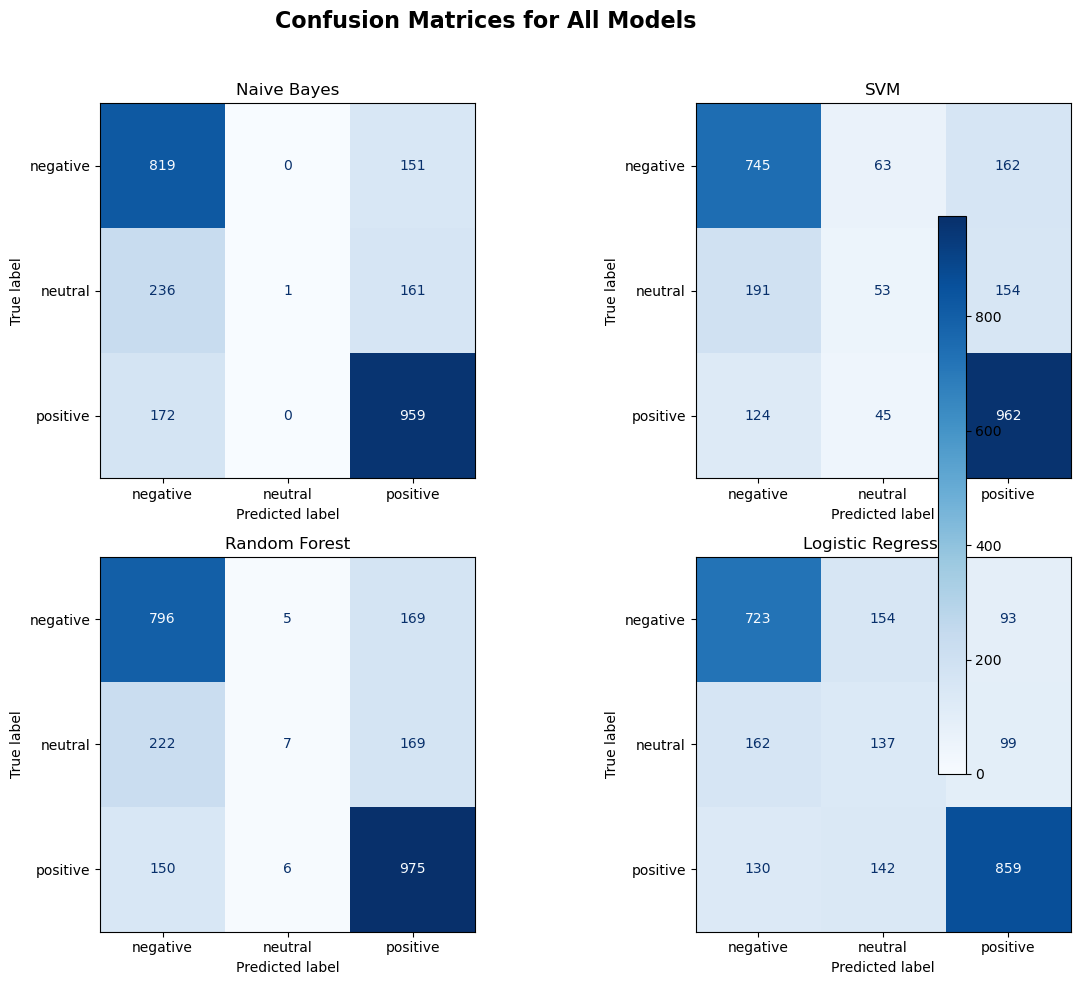

In [45]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

models = [
    (nb_pipeline, "Naive Bayes"),
    (svm_pipeline, "SVM"),
    (rf_pipeline, "Random Forest"),
    (lr_pipeline, "Logistic Regression")
]

fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

cms = []
for model, _ in models:
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred, labels=["negative", "neutral", "positive"])
    cms.append(cm)

vmax_value = np.max(cms) 

for idx, (model, title) in enumerate(models):
    cm = cms[idx]
    disp = ConfusionMatrixDisplay(cm, display_labels=["negative", "neutral", "positive"])
    disp.plot(ax=axes[idx], cmap="Blues", values_format='d', colorbar=False)
    axes[idx].set_title(title)
    im = axes[idx].images[-1]
    im.set_clim(0, vmax_value)

fig.colorbar(im, ax=axes, orientation='vertical', fraction=0.03, pad=0.04)

plt.suptitle("Confusion Matrices for All Models", fontsize=16, fontweight='bold')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


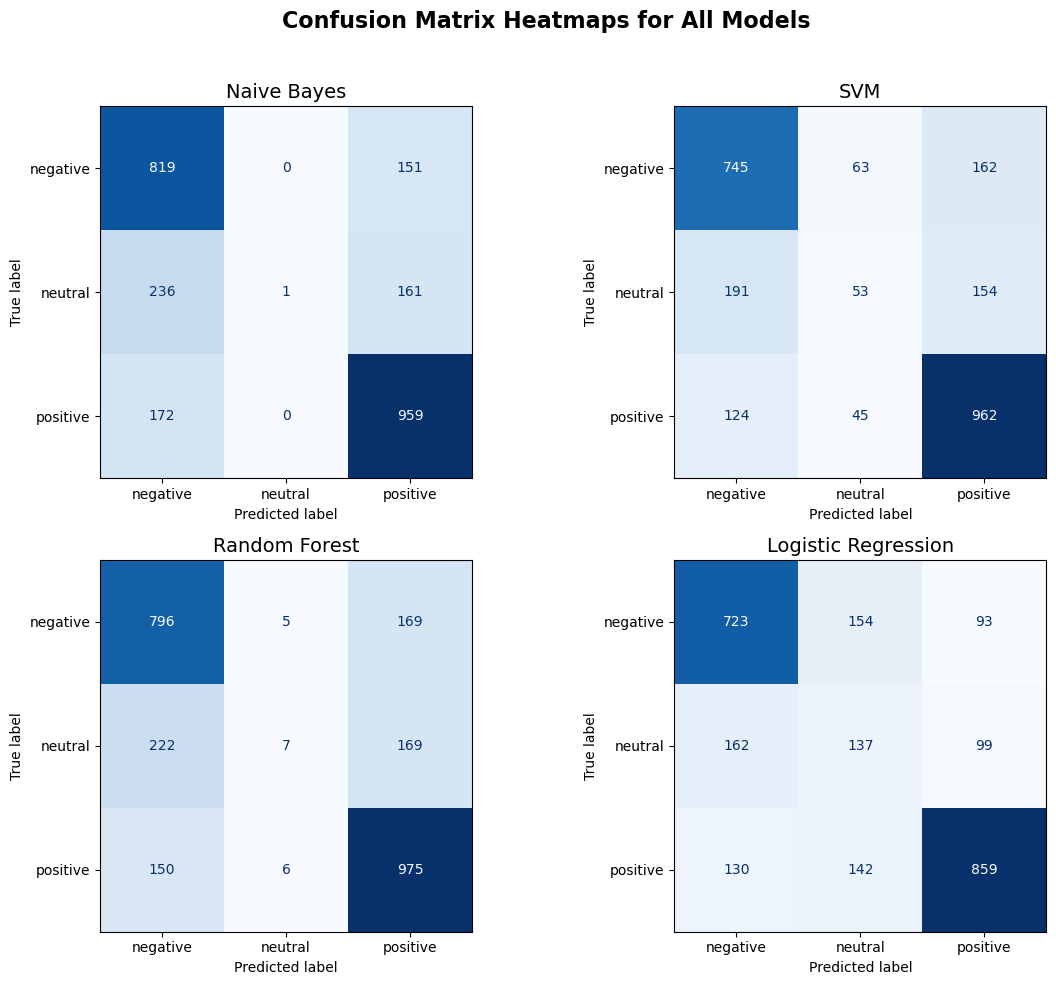

In [46]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

models = [
    (nb_pipeline, "Naive Bayes"),
    (svm_pipeline, "SVM"),
    (rf_pipeline, "Random Forest"),
    (lr_pipeline, "Logistic Regression")
]

fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

for idx, (model, title) in enumerate(models):
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred, labels=["negative", "neutral", "positive"])
    
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["negative", "neutral", "positive"])
    disp.plot(ax=axes[idx], cmap="Blues", values_format='d', colorbar=False)
    axes[idx].set_title(f"{title}", fontsize=14)

plt.suptitle("Confusion Matrix Heatmaps for All Models", fontsize=16, fontweight="bold")
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


In [47]:
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score
import pandas as pd

scoring = {
    'accuracy': make_scorer(accuracy_score),
    'precision_macro': make_scorer(precision_score, average='macro'),
    'recall_macro': make_scorer(recall_score, average='macro'),
    'f1_macro': make_scorer(f1_score, average='macro')
}

models = [
    ("Naive Bayes", nb_pipeline),
    ("SVM", svm_pipeline),
    ("Random Forest", rf_pipeline),
    ("Logistic Regression", lr_pipeline)
]

results_list = []

for name, model in models:
    cv_results = cross_validate(model, X, y, cv=5, scoring=scoring, n_jobs=-1)
    results_list.append({
        "Model": name,
        "Accuracy": cv_results['test_accuracy'].mean(),
        "Precision (Macro)": cv_results['test_precision_macro'].mean(),
        "Recall (Macro)": cv_results['test_recall_macro'].mean(),
        "F1-Score (Macro)": cv_results['test_f1_macro'].mean()
    })

cv_results_df = pd.DataFrame(results_list)
print(cv_results_df)


                 Model  Accuracy  Precision (Macro)  Recall (Macro)  \
0          Naive Bayes  0.703561           0.524664        0.558024   
1                  SVM  0.686435           0.564545        0.563929   
2        Random Forest  0.692517           0.574330        0.552632   
3  Logistic Regression  0.668187           0.590769        0.589654   

   F1-Score (Macro)  
0          0.509572  
1          0.550239  
2          0.513532  
3          0.589077  


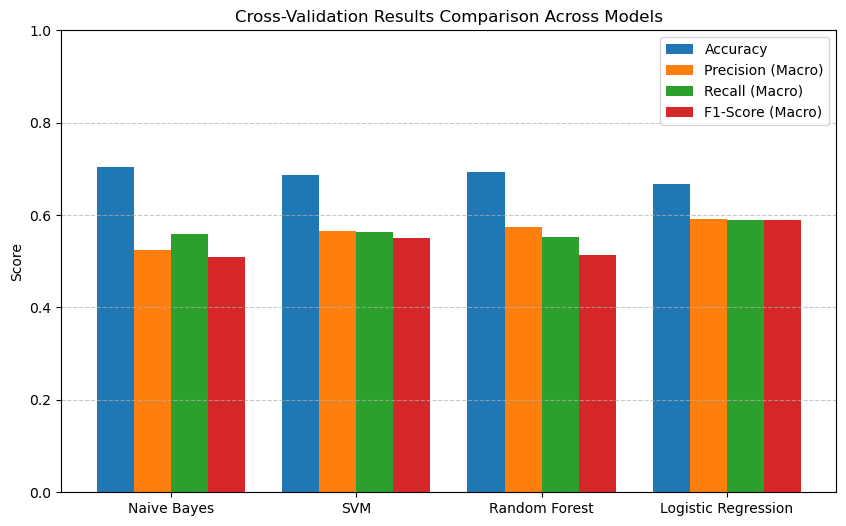

In [48]:
import matplotlib.pyplot as plt
import numpy as np

cv_results_melted = cv_results_df.melt(id_vars="Model", 
                                       var_name="Metric", 
                                       value_name="Score")

plt.figure(figsize=(10, 6))
metrics = cv_results_melted["Metric"].unique()
x = np.arange(len(cv_results_df["Model"]))

bar_width = 0.2

for i, metric in enumerate(metrics):
    metric_scores = cv_results_df[metric]
    plt.bar(x + i * bar_width, metric_scores, width=bar_width, label=metric)

plt.xticks(x + bar_width * (len(metrics)-1) / 2, cv_results_df["Model"])
plt.ylabel("Score")
plt.ylim(0, 1)
plt.title("Cross-Validation Results Comparison Across Models")
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()
